# Timing-associated genes analysis with cellfategenie

In our single-cell analysis, we analyse the underlying temporal state in the cell, which we call pseudotime. and identifying the genes associated with pseudotime becomes the key to unravelling models of gene dynamic regulation. In traditional analysis, we would use correlation coefficients, or gene dynamics model fitting. The correlation coefficient approach will have a preference for genes at the beginning and end of the time series, and the gene dynamics model requires RNA velocity information. Unbiased identification of chronosequence-related genes, as well as the need for no additional dependency information, has become a challenge in current chronosequence analyses.

Here, we developed CellFateGenie, which first removes potential noise from the data through metacells, and then constructs an adaptive ridge regression model to find the minimum set of genes needed to satisfy the timing fit.CellFateGenie has similar accuracy to gene dynamics models while eliminating preferences for the start and end of the time series.



In [17]:
import omicverse as ov
import scvelo as scv
import matplotlib.pyplot as plt
ov.ov_plot_set()

## Data preprocessed

We using dataset of dentategyrus in scvelo to demonstrate the timing-associated genes analysis. Firstly, We use `ov.pp.qc` and `ov.pp.preprocess` to preprocess the dataset.

Then we use `ov.pp.scale` and `ov.pp.pca` to analysis the principal component of the data

In [109]:
adata = scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [110]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250},
              )

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 2930
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 795 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 18.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%
    Scrublet finished (0:00:04)
Cells retained after scrublet: 2928, 2 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower treshold

In [111]:
ov.utils.store_layers(adata,layers='counts')
adata

......The X of adata have been stored in counts


AnnData object with n_obs × n_vars = 2928 × 13118
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'mt', 'n_cells'
    uns: 'clusters_colors', 'scrublet', 'layers_counts'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [112]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=2000)

Begin robust gene identification
After filtration, 13118/13118 genes are kept. Among 13118 genes, 13118 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [113]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 2928 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_colors', 'scrublet', 'layers_counts', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [114]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm["X_mde_pca"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [115]:
adata=adata.raw.to_adata()

<AxesSubplot: title={'center': 'clusters'}, xlabel='X_mde_pca1', ylabel='X_mde_pca2'>

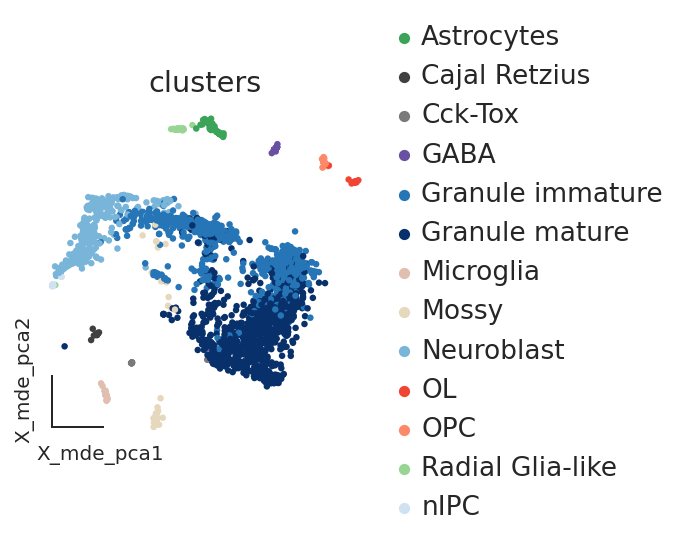

In [373]:
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(adata,
                basis='X_mde_pca',frameon='small',
                color=['clusters'],show=False,ax=ax)

## Meta-cells calculated

To reduce the noisy of the raw dataset and improve the accuracy of the regrssion model. We using `SEACells` to perform the Meta-cells calculated.

In [451]:
import SEACells
adata=adata[adata.obs['clusters']!='Endothelial']
model = SEACells.core.SEACells(adata, 
                  build_kernel_on='scaled|original|X_pca', 
                  n_SEACells=200, 
                  n_waypoint_eigs=10,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [452]:
model.construct_kernel_matrix()
M = model.kernel_matrix
# Initialize archetypes
model.initialize_archetypes()

Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/2841 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/2841 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/2841 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on scaled|original|X_pca
Computing diffusion components from scaled|original|X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
Done.
Sampling waypoints ...
Done.
Selecting 146 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 64/64 [00:00<00:00, 386.11it/s]

Selecting 54 cells from greedy initialization.


In [453]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00084
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 42 iterations.


The model will stop early, we can use `model.step` to force the model run additional iterations. Usually, 100 iters can get the best metacells.

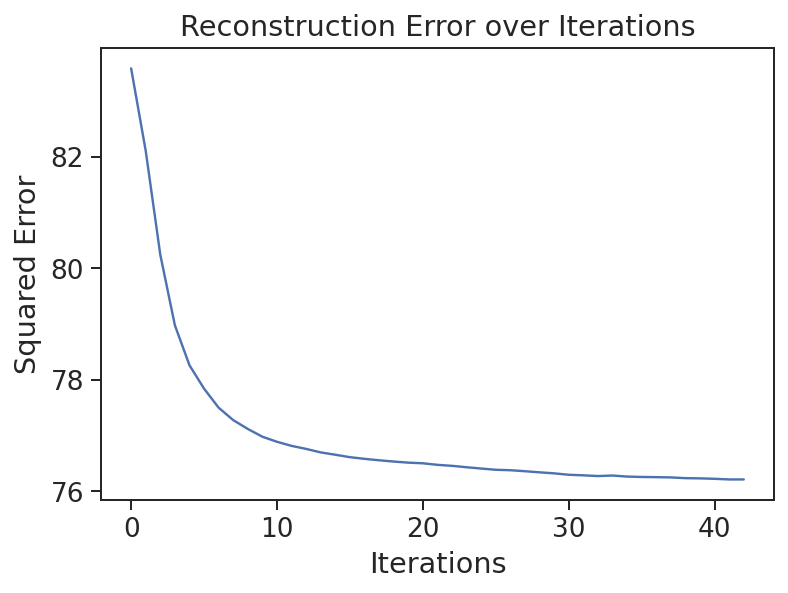

In [454]:
# Check for convergence 
%matplotlib inline
model.plot_convergence()

In [489]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Run for {len(model.RSS_iters)} iterations')
for _ in range(10):
    model.step()
print(f'Run for {len(model.RSS_iters)} iterations')

Run for 93 iterations
Run for 103 iterations


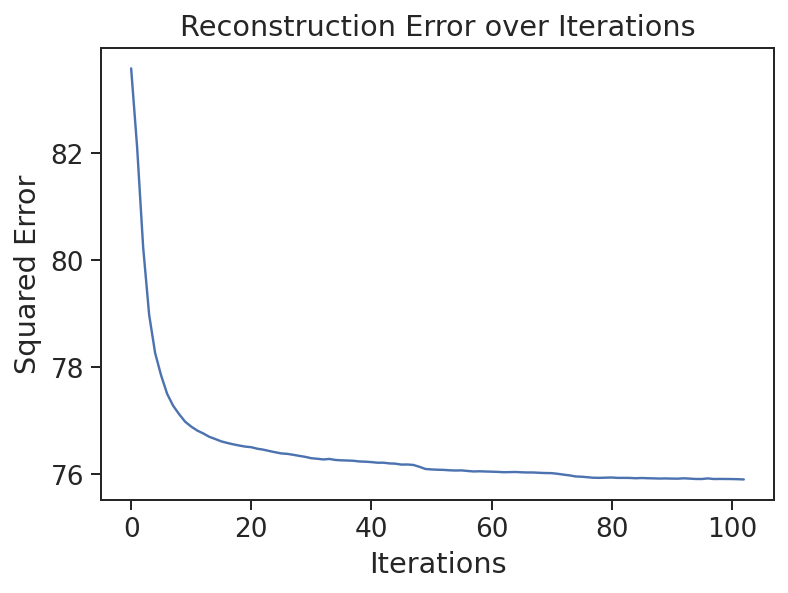

In [490]:
# Check for convergence 
%matplotlib inline
model.plot_convergence()

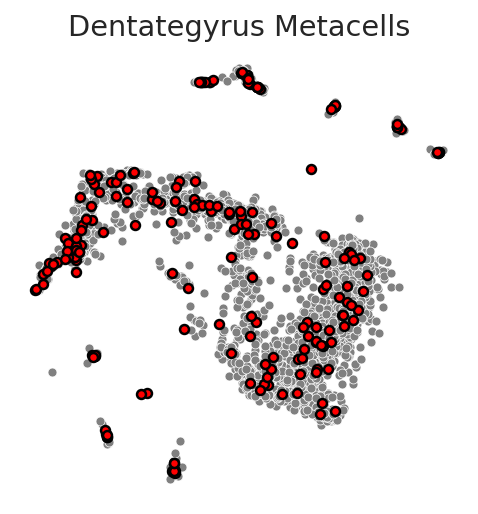

In [491]:
%matplotlib inline
SEACells.plot.plot_2D(adata, key='X_mde_pca', colour_metacells=False,
                     figsize=(4,4),cell_size=20,title='Dentategyrus Metacells',
                     )

We notice the shape of raw anndata not consistent with the HVGs anndata.

In [492]:
adata.raw=adata.copy()

And we use `SEACells.core.summarize_by_soft_SEACell` to get the normalized metacells

In [493]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(adata, model.A_, 
                                                          celltype_label='clusters',
                                                          summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


AnnData object with n_obs × n_vars = 200 × 13118
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

We visualized the metacells with PCA and UMAP

In [494]:
import scanpy as sc
SEACell_soft_ad.raw=SEACell_soft_ad.copy()
sc.pp.highly_variable_genes(SEACell_soft_ad, n_top_genes=2000, inplace=True)
SEACell_soft_ad=SEACell_soft_ad[:,SEACell_soft_ad.var.highly_variable]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [495]:
ov.pp.scale(SEACell_soft_ad)
ov.pp.pca(SEACell_soft_ad,layer='scaled',n_pcs=50)
sc.pp.neighbors(SEACell_soft_ad, use_rep='scaled|original|X_pca')
sc.tl.umap(SEACell_soft_ad)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


And we can use the raw color of anndata.

In [496]:
SEACell_soft_ad.obs['celltype']=SEACell_soft_ad.obs['celltype'].astype('category')
SEACell_soft_ad.obs['celltype']=SEACell_soft_ad.obs['celltype'].cat.reorder_categories(adata.obs['clusters'].cat.categories)
SEACell_soft_ad.uns['celltype_colors']=adata.uns['clusters_colors']

<AxesSubplot: title={'center': 'Meta Celltype'}, xlabel='X_umap1', ylabel='X_umap2'>

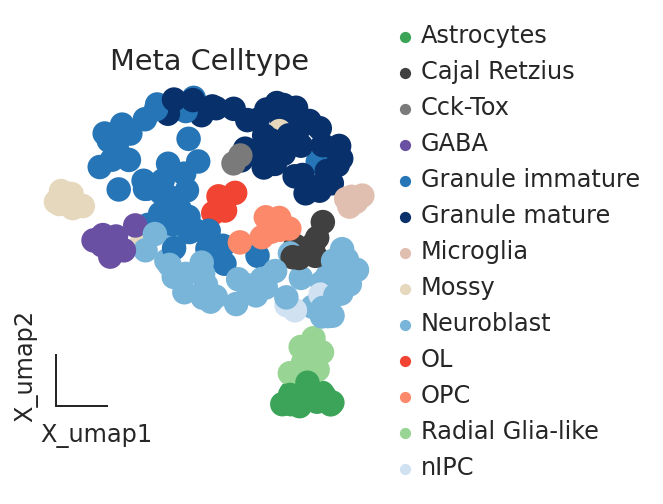

In [497]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(SEACell_soft_ad,
                   basis='X_umap',
                   color=["celltype"],
                   title='Meta Celltype',
                   frameon='small',
                   legend_fontsize=12,
                   #palette=ov.utils.palette()[11:],
                   ax=ax,
                   show=False)

## Pseudotime calculated

Accurately calculating the pseudotime in metacells is another challenge we need to face, here we use pyVIA to complete the calculation of the pseudotime. Since the metacell has only 200 cells, we may not get proper proposed time series results by using the default parameters of pyVIA, so we manually adjust the relevant parameters.

We need to set `jac_std_global`, `too_big_factor` and `knn` manually. If you know the origin cells, set the `root_user` is helpful too.

In [499]:
v0 = ov.single.pyVIA(adata=SEACell_soft_ad,adata_key='scaled|original|X_pca',
                         adata_ncomps=50, basis='X_umap',
                         clusters='celltype',knn=10, root_user=['nIPC','Neuroblast'],
                         dataset='group', 
                         random_seed=112,is_coarse=True, 
                         preserve_disconnected=True,
                         piegraph_arrow_head_width=0.05,piegraph_edgeweight_scalingfactor=2.5,
                         gene_matrix=SEACell_soft_ad.X,velo_weight=0.5,
                         edgebundle_pruning_twice=False, edgebundle_pruning=0.15, 
                         jac_std_global=0.05,too_big_factor=0.05,
                         cluster_graph_pruning_std=1,
                         time_series=False,
                        )

v0.run()

2023-08-19 20:30:44.914528	Running VIA over input data of 200 (samples) x 50 (features)
2023-08-19 20:30:44.914572	Knngraph has 10 neighbors
2023-08-19 20:30:44.929534	Finished global pruning of 10-knn graph used for clustering at level of 0.05. Kept 47.4 % of edges. 
2023-08-19 20:30:44.930508	Number of connected components used for clustergraph  is 1
2023-08-19 20:30:44.932367	Commencing community detection
2023-08-19 20:30:44.934054	Finished running Leiden algorithm. Found 29 clusters.
2023-08-19 20:30:44.934117	Found 7 clusters that are too big
2023-08-19 20:30:44.934125	Examining clusters that are above the too_big threshold
2023-08-19 20:30:44.934136	Cluster 1 contains 18>10 samples and is too big
2023-08-19 20:30:44.935696	Could not expand cluster 1
2023-08-19 20:30:44.935710	Examining clusters that are above the too_big threshold
2023-08-19 20:30:44.935718	Cluster 0 contains 23>10 samples and is too big
2023-08-19 20:30:44.937297	Examining clusters that are above the too_big th

In [500]:
v0.get_pseudotime(SEACell_soft_ad)

...the pseudotime of VIA added to AnnData obs named `pt_via`


<AxesSubplot: title={'center': 'Pseudotime'}, xlabel='X_umap1', ylabel='X_umap2'>

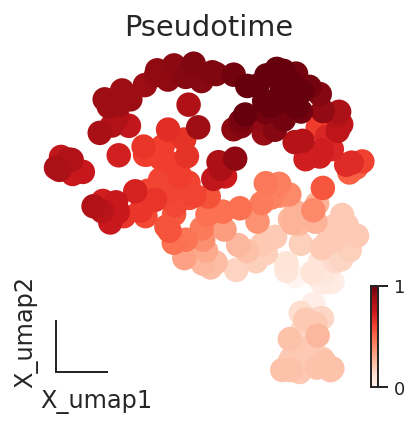

In [501]:
#v0.get_pseudotime(SEACell_soft_ad)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(SEACell_soft_ad,
                   basis='X_umap',
                   color=["pt_via"],
                   title='Pseudotime',
                   frameon='small',
                   cmap='Reds',
                   #size=40,
                   legend_fontsize=12,
                   #palette=ov.utils.palette()[11:],
                   ax=ax,
                   show=False)

Now we save the result of metacells for under analysis.

In [502]:
SEACell_soft_ad.write_h5ad('data/tutorial_meta_den.h5ad',compression='gzip')

In [ ]:
SEACell_soft_ad=ov.read('data/tutorial_meta_den.h5ad')

## Timing-associated genes analysis

We have encapsulated the cellfategenie algorithm into omicverse, and we can simply use omicverse to analysis.

In [503]:
cfg_obj=ov.single.cellfategenie(SEACell_soft_ad,pseudotime='pt_via')
cfg_obj.model_init()

$MSE|RMSE|MAE|R^2$:0.005|0.071|0.052|0.95


,coef,abs(coef),values
index,,,
Cck,1.534340e-02,1.534340e-02,2.014104
Vmp1,1.285277e-02,1.285277e-02,1.332738
Tubb2b,-1.262071e-02,1.262071e-02,3.710152
Nrsn1,1.255942e-02,1.255942e-02,1.482649
Stmn2,-1.248511e-02,1.248511e-02,3.239698
...,...,...,...
Itga6,-3.113411e-06,3.113411e-06,0.226160
Rac2,-2.678432e-06,2.678432e-06,0.084465
Mfng,-1.336850e-06,1.336850e-06,0.095053


We used Adaptive Threshold Regression to calculate the minimum number of gene sets that would have the same accuracy as the regression model constructed for all genes.

In [504]:
cfg_obj.ATR(stop=500)

coef_threshold:0.0035396520979702473, r2:0.9465739370724419


,coef_threshold,r2
0,0.012853,0.588356
1,0.012621,0.538530
2,0.012559,0.759977
3,0.012485,0.761421
4,0.011894,0.782412
...,...,...
495,0.001991,0.954950
496,0.001989,0.954913
497,0.001983,0.954957
498,0.001978,0.954938


Text(0.5, 1.0, 'Dentategyrus Metacells\nCellFateGenie')

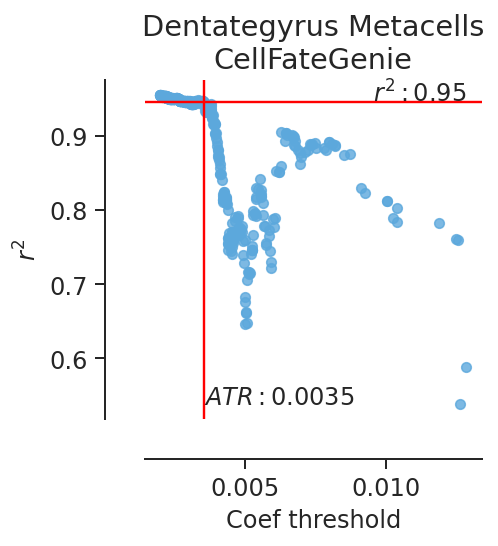

In [505]:
fig,ax=cfg_obj.plot_filtering(color='#5ca8dc')
ax.set_title('Dentategyrus Metacells\nCellFateGenie')

In [506]:
res=cfg_obj.model_fit()

$MSE|RMSE|MAE|R^2$:0.0073|0.085|0.066|0.92


## Visualization

We prepared a series of function to visualize the result. we can use `plot_color_fitting` to observe the different cells how to transit with the pseudotime.

(<Figure size 216x216 with 1 Axes>,
 <AxesSubplot: title={'center': 'Regression Genes\nDimension: 2000'}, xlabel='True pseudotime', ylabel='Predicted pseudotime'>)

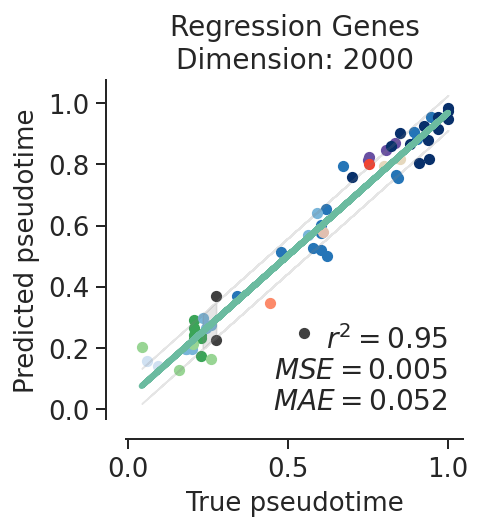

In [507]:
cfg_obj.plot_color_fitting(type='raw',cluster_key='celltype')

(<Figure size 216x216 with 1 Axes>,
 <AxesSubplot: title={'center': 'Regression Genes\nDimension: 210'}, xlabel='True pseudotime', ylabel='Predicted pseudotime'>)

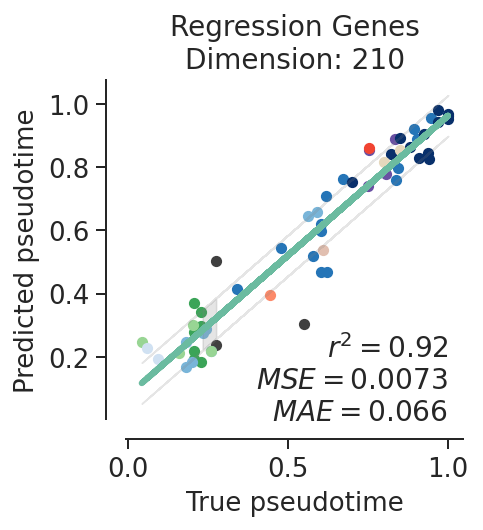

In [508]:
cfg_obj.plot_color_fitting(type='filter',cluster_key='celltype')

## Kendalltau test

We can further narrow down the set of genes that satisfy the maximum regression coefficient. We used the kendalltau test to calculate the trend significance for each gene.

In [509]:
kt_filter=cfg_obj.kendalltau_filter()
kt_filter.head()

,kendalltau_sta,pvalue
Mbip,0.107809,2.577171e-02
Cntnap1,0.560674,1.174880e-28
Tmem130,0.278101,2.008062e-08
Hexa,0.015240,7.517154e-01
Snap91,0.288661,3.288329e-09


In [510]:
var_name=kt_filter.loc[kt_filter['pvalue']<kt_filter['pvalue'].mean()].index.tolist()
gt_obj=ov.single.gene_trends(SEACell_soft_ad,'pt_via',var_name)
gt_obj.calculate(n_convolve=10)

In [511]:
print(f"Dimension: {len(var_name)}")

Dimension: 176


Text(0.5, 1.0, 'Dentategyrus meta\nCellfategenie')

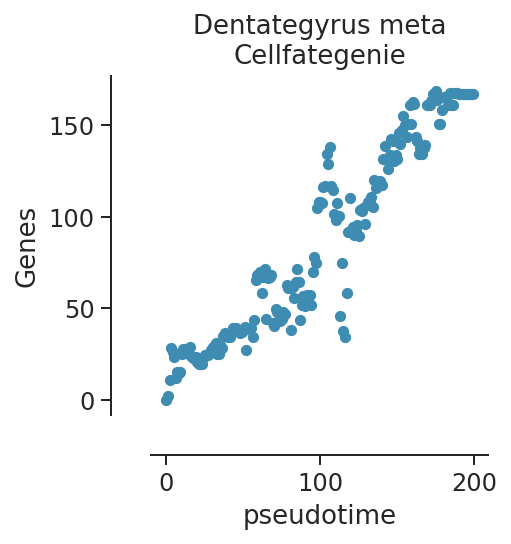

In [512]:
fig,ax=gt_obj.plot_trend(color=ov.utils.blue_color[3])
ax.set_title(f'Dentategyrus meta\nCellfategenie',fontsize=13)

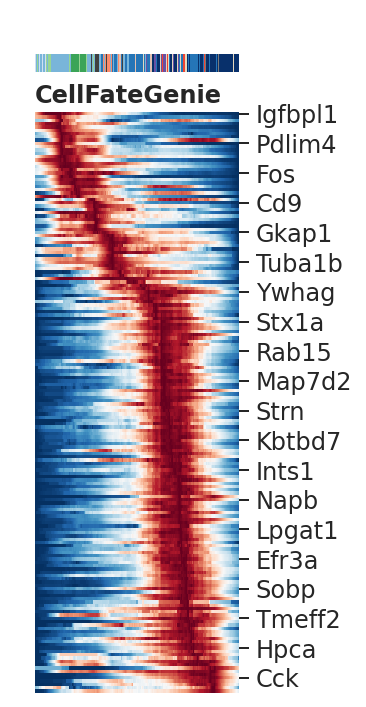

In [515]:
g=ov.utils.plot_heatmap(SEACell_soft_ad,var_names=var_name,
                  sortby='pt_via',col_color='celltype',
                 n_convolve=50,figsize=(1,6),show=False)

g.fig.set_size_inches(2, 6)
g.fig.suptitle('CellFateGenie',x=0.25,y=0.83,
               horizontalalignment='left',fontsize=12,fontweight='bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=12)
plt.show()